In [1]:
#%load_ext autoreload
#%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
from amwag.app_utilities.preprocessing import *
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.filterwarnings("ignore")

from sklearn import set_config
set_config(transform_output="pandas")

RSEED = 5

In [2]:
df = pd.read_csv("../data/AQUASTAT_complete.csv", index_col=0)

pre-split preprocessing

In [3]:
pre_split_processor = get_pre_split_processor()

In [4]:
df_pre = pre_split_processor.transform(df)
df_pre.shape

(8575, 41)

limit years here!

In [5]:
df_pre = df_pre.query("year > 2000")

In [6]:
df_pre.head()

,country,year,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
37,Afghanistan,2001,44.702708,100.0,11.875440,20.0,30.613807,98.518576,54.063068,7753.0,...,47.15,2182.164400,21606.988,32.0,10.65,3023.558860,20.30074,939.545114,4648.139,18.18
38,Afghanistan,2002,44.684011,100.0,11.875440,20.0,30.613807,98.431107,45.134344,7753.0,...,47.15,2086.212107,22600.770,33.8,10.65,2890.609479,20.31878,899.030431,4893.013,18.18
39,Afghanistan,2003,37.646401,100.0,12.115921,20.0,30.613807,98.343792,41.903476,7910.0,...,47.15,1991.058521,23680.871,35.5,10.65,2758.766770,20.33682,858.786824,5155.788,18.18
40,Afghanistan,2004,53.059409,100.0,12.117452,20.0,30.613807,98.256633,35.612891,7911.0,...,47.15,1906.846870,24726.684,37.3,10.65,2642.084964,20.35486,823.194085,5426.872,18.18
41,Afghanistan,2005,43.148507,100.0,12.115921,20.0,30.613807,98.169627,35.147545,7910.0,...,47.15,1837.900168,25654.277,39.1,10.65,2546.553933,20.37290,794.132690,5691.836,18.18


In [7]:
df_ts = df_pre.sort_values("year").set_index("year")

In [8]:
df_ts

,country,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2001,Afghanistan,44.702708,100.000000,11.875440,20.000000,30.613807,98.518576,54.063068,7753.0000,92.979179,...,47.150,2182.164400,21606.988,32.0,10.650,3023.558860,20.300740,939.545114,4648.139,18.18
2001,Belgium,NaN,100.000000,28.358991,0.037200,0.203279,0.521242,1.109350,865.8000,13.983887,...,12.000,1162.901241,10319.019,100.0,0.900,1773.424392,7.136800,691.616131,10028.603,6.30
2001,Mauritius,NaN,100.000000,46.568627,0.467840,17.006184,72.160428,5.887679,95.0000,56.427708,...,2.751,2304.180274,1193.917,99.3,0.893,2304.180274,0.648333,543.030490,508.114,0.00
2001,Mauritania,24.845746,52.400577,0.448239,1.430750,12.550439,93.078099,24.868960,462.0000,185.020722,...,0.400,148.016578,2702.400,43.3,0.300,4218.472469,1.537150,568.809207,1077.677,11.00
2001,United Kingdom of Great Britain and Northern I...,NaN,100.000000,23.406264,1.833000,1.246939,12.079873,0.782121,5702.0000,89.159636,...,145.000,2452.460823,59124.288,100.0,9.800,2486.287869,15.174000,256.645797,46580.884,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,Guatemala,24.809144,100.000000,18.780421,1.886000,1.474474,56.737162,10.243420,2045.0000,25.890338,...,109.200,6095.257488,17915.568,92.8,33.700,7139.600598,3.324100,185.542540,9284.293,18.71
2020,Greece,43.051419,100.000000,24.402547,8.107000,11.852339,80.092867,4.230805,3220.1601,1182.187102,...,58.000,5564.587884,10423.054,100.0,10.300,6562.376056,10.122000,971.116527,8850.409,10.40
2020,Philippines,34.760355,94.812910,37.250000,67.830825,14.160924,78.995084,10.184808,11175.0000,64.837836,...,479.000,4371.192625,109581.078,91.8,180.000,4371.192625,85.867147,783.594655,52008.603,0.00


In [9]:
for c in df_ts.country.unique():
    df_1 = df_ts.query("country == @c")
    if df_1.isna().sum().sum() > 10:
        print(c)

Mauritius
United Kingdom of Great Britain and Northern Ireland
Malta
Luxembourg
Lithuania
Bhutan
Latvia
Lao People's Democratic Republic
Kuwait
Jordan
Philippines
Peru
Azerbaijan


Paraguay
Panama
Palestine
Bahrain
Oman
North Macedonia
Bangladesh
Barbados
United Arab Emirates
Nepal
Belarus
Norway
Puerto Rico
Ethiopia
Canada
Egypt
Central African Republic
Yemen
Chad
Chile
Croatia
Costa Rica
Comoros
Democratic People's Republic of Korea
Finland
Israel
Iraq
Indonesia
Iceland
Honduras
Guyana
Burundi
Germany
Gambia
Cambodia
Qatar
Switzerland
Australia
Turkmenistan
Rwanda
Thailand
Sri Lanka
Republic of Korea
Slovenia
Timor-Leste
Saudi Arabia
South Sudan


In [10]:
df_1 = df_ts.query("country == 'Chad'")
df_1.isna().sum().sum()

40

In [11]:
df_int = df_1.drop("country", axis=1).interpolate(axis=1)
df_int.isna().sum().sum()

0

In [12]:
df_int

,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,dependency_ratio,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2001,0.958824,16.910839,3.060748,0.637253,1.394427,77.682243,36.605330,3930.0,1998.588621,67.177243,...,15.0,1728.498715,8678.051,45.2,11.5,5266.159418,0.820333,94.529674,1877.232,30.7
2002,0.990247,17.135515,2.904984,0.672200,1.470897,78.039380,34.445495,3730.0,1898.588621,67.177243,...,15.0,1663.112595,9019.233,45.7,11.5,5066.949706,0.861360,95.502578,1953.584,30.7
2003,0.990247,17.135515,2.982866,0.672200,1.470897,77.492391,40.159436,3830.0,1948.588621,67.177243,...,15.0,1600.185024,9373.916,46.2,11.5,4875.230373,0.867440,92.537633,2032.953,30.7
2004,0.990247,17.135515,2.982866,0.672200,1.470897,76.953018,28.339881,3830.0,1948.588621,67.177243,...,15.0,1540.868929,9734.767,46.7,11.5,4694.514003,0.873520,89.731988,2113.721,30.7
2005,0.990247,17.135515,3.060748,0.672200,1.470897,76.421101,25.757433,3930.0,1998.588621,67.177243,...,15.0,1485.643778,10096.633,47.2,11.5,4526.261378,0.879600,87.118151,2194.746,30.7
2006,0.990247,17.135515,3.060748,0.672200,1.470897,76.421101,26.833061,3930.0,1998.588621,67.177243,...,15.0,1434.428816,10457.124,47.7,11.5,4370.226460,0.879600,84.114906,2275.496,30.7
2007,0.990247,17.135515,3.061526,0.672200,1.470897,76.421101,24.499453,3931.0,1999.088621,67.177243,...,15.0,1386.574850,10818.024,48.2,11.5,4224.431375,0.879600,81.308749,2356.380,30.7
2008,0.990247,17.135515,3.061526,0.672200,1.470897,76.421101,25.099725,3931.0,1999.088621,67.177243,...,15.0,1341.251126,11183.588,48.7,11.5,4086.345098,0.879600,78.650966,2438.393,30.7
2009,0.990247,17.135515,3.142523,0.672200,1.470897,76.421101,28.856460,4035.0,2051.088621,67.177243,...,15.0,1297.561355,11560.147,49.2,11.5,3953.236927,0.879600,76.088998,2523.000,30.7


In [13]:
def get_const_columns(df):
    # Get the number of unique values in each column
    unique_values = df.nunique()

    # Get the constant columns
    constant_columns = unique_values[unique_values == 1].index.tolist()

    return constant_columns

In [14]:
x0 = np.array(list(range(10))).reshape(10,1)
y0 = np.array([1,1,2,3,4,4,4,3,6,7]).reshape(10,1)
y1 = y0*3-10

Y = np.concatenate([y0, y1], axis=1)
Y

array([[ 1, -7],
       [ 1, -7],
       [ 2, -4],
       [ 3, -1],
       [ 4,  2],
       [ 4,  2],
       [ 4,  2],
       [ 3, -1],
       [ 6,  8],
       [ 7, 11]])

In [15]:
poly = PolynomialFeatures(4)
xp = poly.fit_transform(x0)
xp

,1,x0,x0^2,x0^3,x0^4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,2.0,4.0,8.0,16.0
3,1.0,3.0,9.0,27.0,81.0
4,1.0,4.0,16.0,64.0,256.0
5,1.0,5.0,25.0,125.0,625.0
6,1.0,6.0,36.0,216.0,1296.0
7,1.0,7.0,49.0,343.0,2401.0
8,1.0,8.0,64.0,512.0,4096.0
9,1.0,9.0,81.0,729.0,6561.0


In [16]:
lin = LinearRegression()

lin_pipe = Pipeline([
    ("poly", poly),
    ("lin", lin)
])

lin_pipe.fit(x0, Y)

yp = lin_pipe.predict(x0)
print(yp)

[[ 0.90909091 -7.27272727]
 [ 1.15384615 -6.53846154]
 [ 2.05710956 -3.82867133]
 [ 3.01981352 -0.94055944]
 [ 3.68764569  1.06293706]
 [ 3.95104895  1.85314685]
 [ 3.94522145  1.83566434]
 [ 4.05011655  2.15034965]
 [ 4.89044289  4.67132867]
 [ 7.33566434 12.00699301]]


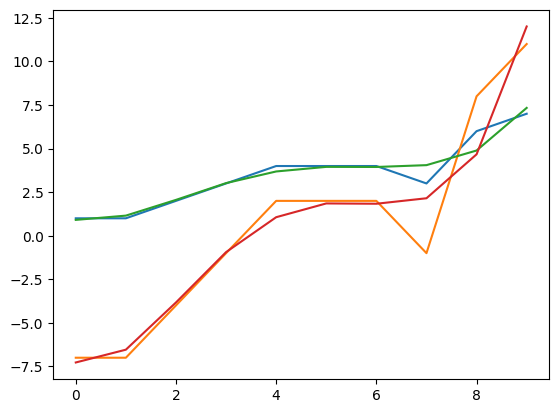

In [17]:
fig = plt.figure()
plt.plot(x0, y0)
plt.plot(x0, y1)
plt.plot(x0, yp)

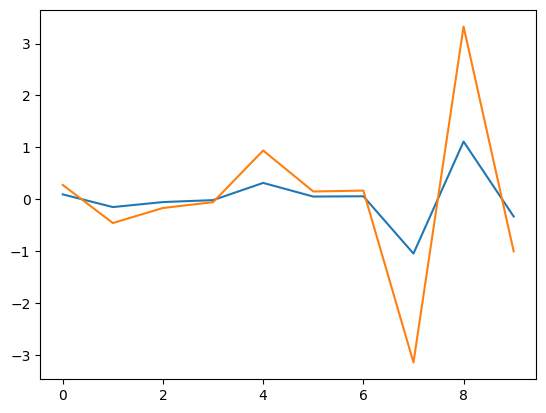

In [18]:
fig = plt.figure()
plt.plot(x0, Y-yp)

In [19]:
def get_linear_model(x):
    deg = 1
    r2 = 0
    while r2 < 0.7 and deg<20:
        poly = PolynomialFeatures(degree=deg)
        lin = LinearRegression()

        lin_pipe = Pipeline([
            ("poly", poly),
            ("lin", lin)
        ])
        xi = np.array(x.index).reshape(len(x.index),1)
        lin_pipe.fit(xi, x)
        xp = lin_pipe.predict(xi)
        r2 = r2_score(x, xp)
        # print(r2)
        deg += 1

    return lin_pipe

def get_linear_models(X):
    linear_models = {}
    for col in X.columns:
        model = get_linear_model(X[col])
        linear_models[col] = model
    return linear_models

In [20]:
def get_linear(df, model_dict, ii):
    df_new = df.copy()
    for col in df.columns:
        df_new[col] = model_dict[col].predict(ii)
    return df_new

In [21]:
#creating the train and validation set
train = df_int.query("index < 2015")
valid = df_int.query("index >= 2015")

const_cols = get_const_columns(train)
train = train.drop(columns=const_cols)
valid = valid.drop(columns=const_cols)

lin_models = get_linear_models(train)

ti = np.array(train.index).reshape(len(train.index),1)
vi = np.array(valid.index).reshape(len(valid.index),1)

t_lin = get_linear(train, lin_models, ti)
v_lin = get_linear(valid, lin_models, vi)

train_stat = train.subtract(t_lin)
valid_stat = valid.subtract(v_lin)

In [22]:
model = VAR(endog=train_stat, )
model_fit = model.fit()

# make prediction on validation
steps = len(valid_stat)
prediction = model_fit.forecast(model_fit.endog, steps=steps)

In [23]:
#converting predictions to dataframe
cols = train_stat.columns.to_list()
pred = pd.DataFrame(index=range(0,len(prediction)),columns=cols)
for j in range(0,len(cols)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

rmse_sum = 0
#check rmse
for e, i in enumerate(cols):
    #print(e, i)
    #display(pred[i])
    rmse = np.sqrt(mean_squared_error(pred[i], valid_stat[i]))
    #print('rmse value for', i, 'is : ', rmse)
    rmse_sum += rmse
rmse_sum

2821.0971099942403

In [24]:
pred.set_index(valid_stat.index, inplace=True)

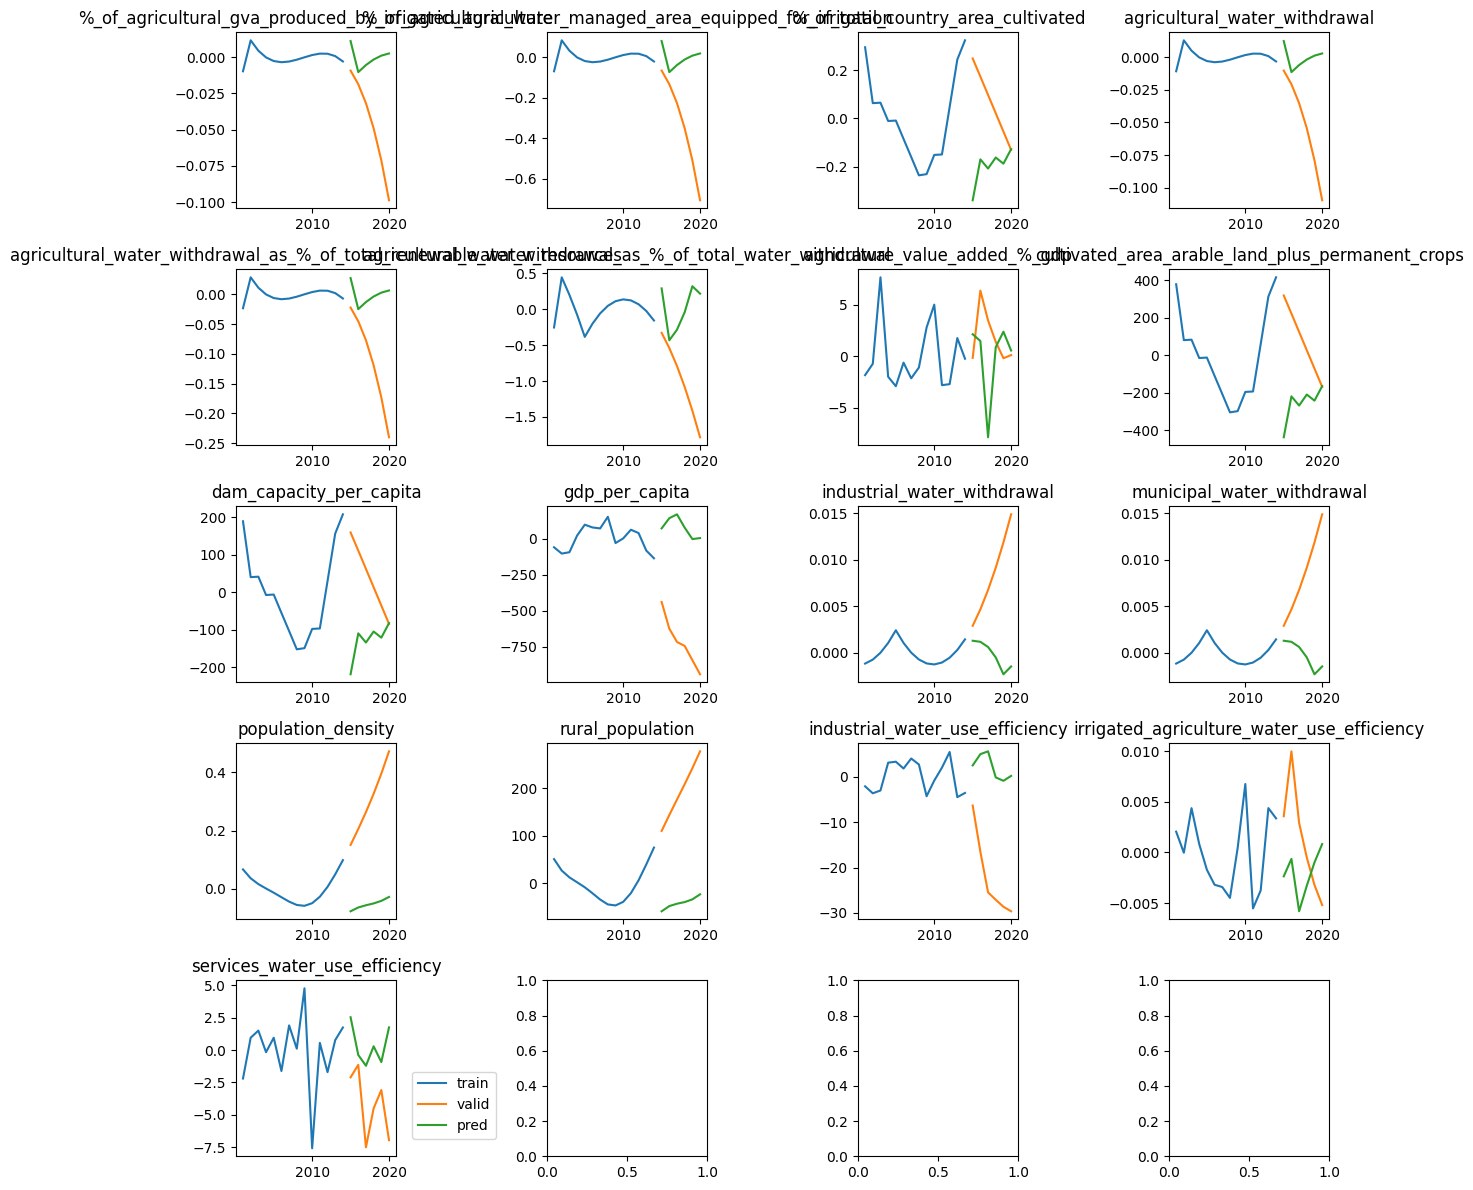

In [25]:
fig, axs = plt.subplots(5, 4, figsize=(12,12))
cols = valid_stat.columns.tolist()

for i, ax in enumerate(axs.flat):
    if i<=16:
        ax.plot(train_stat[cols[i]], label="train")
        ax.plot(valid_stat[cols[i]], label="valid")
        ax.plot(pred[cols[i]], label="pred")
        ax.set_title(cols[i])
    if i==16:
        ax.legend(loc=(1.1, 0.1))
fig.tight_layout()

In [26]:
pred_trans = pred.add(v_lin)

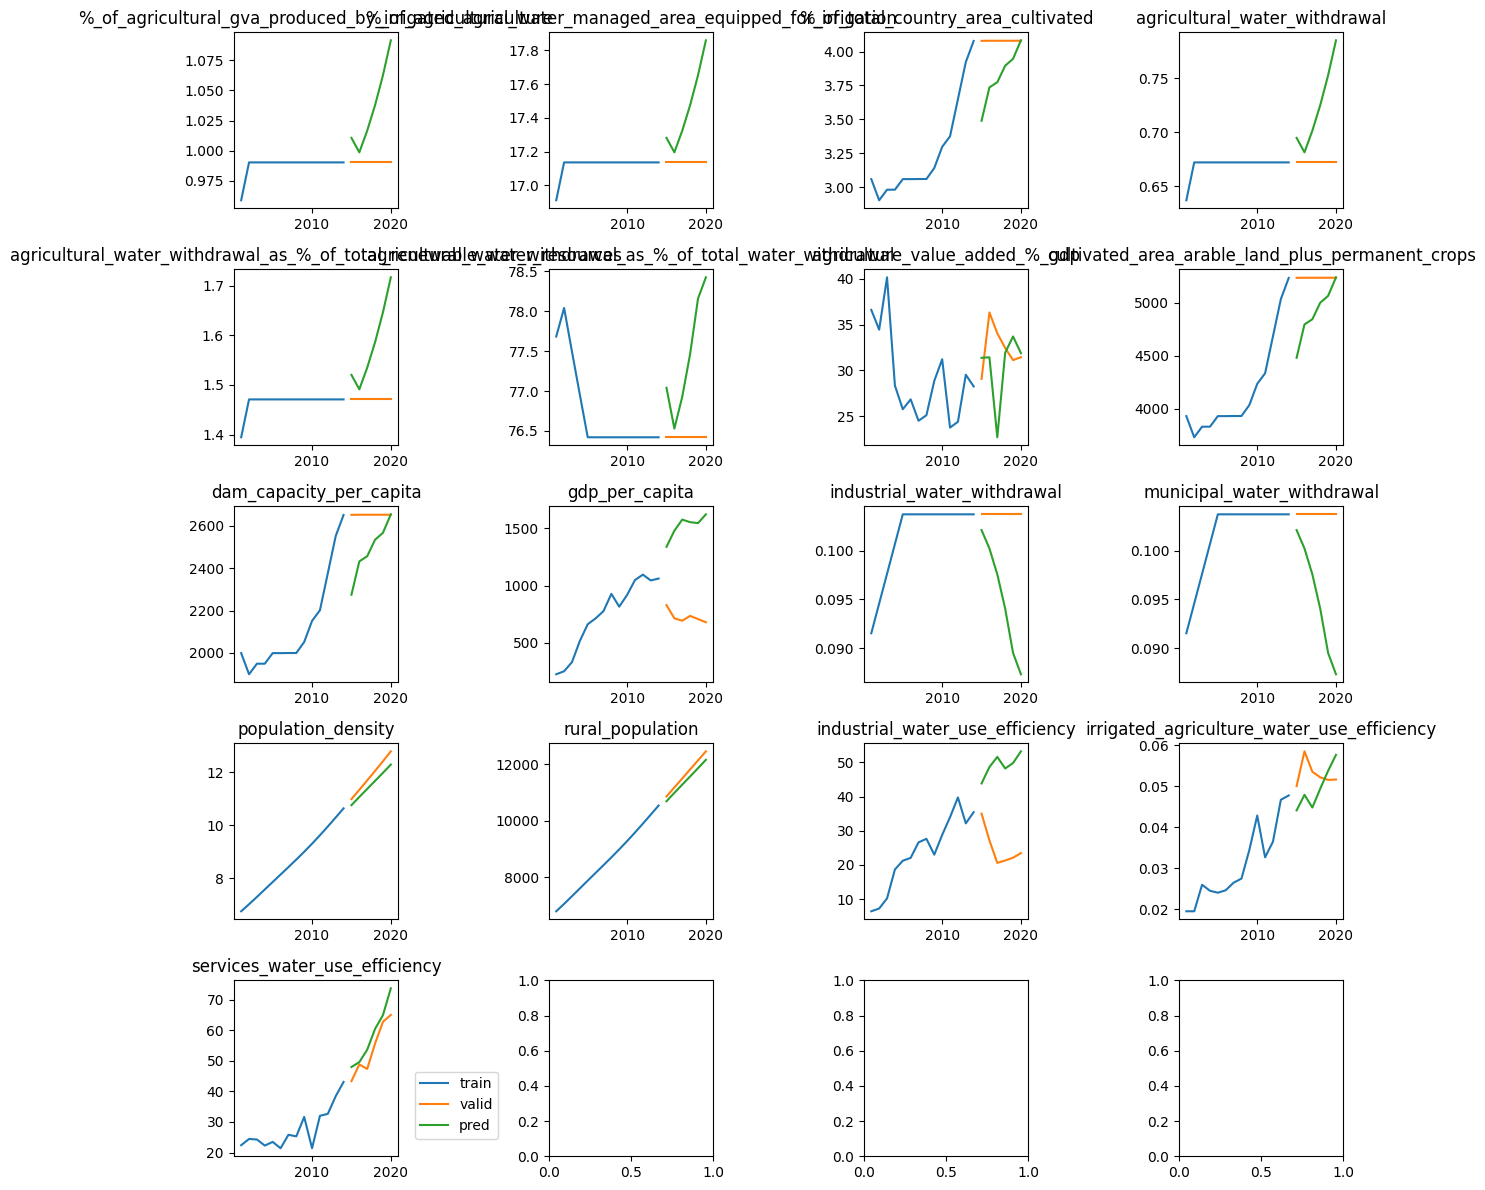

In [27]:
fig, axs = plt.subplots(5, 4, figsize=(12,12))
cols = valid.columns.tolist()

for i, ax in enumerate(axs.flat):
    if i<=16:
        ax.plot(train[cols[i]], label="train")
        ax.plot(valid[cols[i]], label="valid")
        ax.plot(pred_trans[cols[i]], label="pred")
        ax.set_title(cols[i])
    if i==16:
        ax.legend(loc=(1.1, 0.1))
fig.tight_layout()

In [28]:
train

,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,gdp_per_capita,...,water_use_efficiency,water_stress,total_agricultural_water_managed_area,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population
year,,,,,,,,,,,,,,,,,,,,,
2001,0.958824,16.910839,3.060748,0.637253,1.394427,77.682243,36.605330,3930.0,1998.588621,224.096961,...,3.235016,4.005534,172.155857,1728.498715,8678.051,45.2,5266.159418,0.820333,94.529674,1877.232
2002,0.990247,17.135515,2.904984,0.672200,1.470897,78.039380,34.445495,3730.0,1898.588621,250.627556,...,3.495515,4.205859,176.674000,1663.112595,9019.233,45.7,5066.949706,0.861360,95.502578,1953.584
2003,0.990247,17.135515,2.982866,0.672200,1.470897,77.492391,40.159436,3830.0,1948.588621,330.372749,...,3.900557,4.235547,176.674000,1600.185024,9373.916,46.2,4875.230373,0.867440,92.537633,2032.953
2004,0.990247,17.135515,2.982866,0.672200,1.470897,76.953018,28.339881,3830.0,1948.588621,515.847613,...,4.739105,4.265234,176.674000,1540.868929,9734.767,46.7,4694.514003,0.873520,89.731988,2113.721
2005,0.990247,17.135515,3.060748,0.672200,1.470897,76.421101,25.757433,3930.0,1998.588621,661.667309,...,5.290872,4.294922,176.674000,1485.643778,10096.633,47.2,4526.261378,0.879600,87.118151,2194.746
2006,0.990247,17.135515,3.060748,0.672200,1.470897,76.421101,26.833061,3930.0,1998.588621,712.732669,...,5.145313,4.294922,176.674000,1434.428816,10457.124,47.7,4370.226460,0.879600,84.114906,2275.496
2007,0.990247,17.135515,3.061526,0.672200,1.470897,76.421101,24.499453,3931.0,1999.088621,776.242564,...,6.201605,4.294922,176.674000,1386.574850,10818.024,48.2,4224.431375,0.879600,81.308749,2356.380
2008,0.990247,17.135515,3.061526,0.672200,1.470897,76.421101,25.099725,3931.0,1999.088621,927.055828,...,6.264071,4.294922,176.674000,1341.251126,11183.588,48.7,4086.345098,0.879600,78.650966,2438.393
2009,0.990247,17.135515,3.142523,0.672200,1.470897,76.421101,28.856460,4035.0,2051.088621,815.259687,...,6.470361,4.294922,176.674000,1297.561355,11560.147,49.2,3953.236927,0.879600,76.088998,2523.000


try VARIMA (multivariate) or holt winters exponential smoothing (univariate). ds-time-series 04

transform back from differencing:

In [29]:
# # Suppose you have already fitted your VARIMA model and generated forecasts
# forecast_steps = 10  # Adjust as needed
# forecast = results.forecast(steps=forecast_steps)

# # Reverse the differencing to obtain forecasts for 'ts1'
# original_series = df['ts1'].iloc[-1] + np.cumsum(forecast['ts1_diff'])

# # 'original_series' now contains forecasts for 'ts1'

prepare countrywise fitting

In [30]:
def impute_country(df, country):
    df_c = df.query("country == @c")
    df_c = df_c.drop("country", axis=1).interpolate(axis=1)
    df_c = df_c.fillna(method='bfill')
    return df_c

def get_lin_and_stat(df):
    lin_models = get_linear_models(df)
    dfi = np.array(df.index).reshape(len(df.index), 1)
    df_lin = get_linear(df, lin_models, dfi)
    df_stat = df.subtract(df_lin)
    return df_lin, df_stat, lin_models

def fit_and_predict_stat(df, steps, first_index):
    model = VAR(endog=df)
    model_fit = model.fit()
    prediction = model_fit.forecast(model_fit.endog, steps=steps)
    df_pred = transform_to_df(df, prediction, steps, first_index)
    return df_pred

def predict_lin(model_dict, steps, first_index):
    df_new = pd.DataFrame(columns=model_dict.keys())
    ii = np.arange(first_index, first_index+steps, 1)
    for col in df_new.columns:
        df_new[col] = model_dict[col].predict(ii.reshape(-1,1))
    df_new.index = pd.Series(name="year", data=ii)
    return df_new

def transform_to_df(df, pred, steps, first_index):
    years = np.arange(first_index, first_index+steps, 1)
    cols = df.columns.to_list()
    df_pred = pd.DataFrame(index=pd.Series(name="year", data=years), columns=cols)
    for j in range(0,len(cols)):
        for i in range(0, len(pred)):
            df_pred.iloc[i][j] = pred[i][j]
    return df_pred


In [31]:
# country_forecast_dfs = []
# first_index = 2021
# fc_steps = 5

# for i, c in enumerate(df_ts.country.unique()):
#     print(i, c)
#     df_c = impute_country(df_ts, c)
#     const_cols = get_const_columns(df_c)
#     df_train = df_c.drop(columns=const_cols)
#     df_lin, df_stat, lin_models = get_lin_and_stat(df_train)
#     df_pred_stat = fit_and_predict_stat(df_stat, fc_steps, first_index)
#     df_pred_lin = predict_lin(lin_models, fc_steps, first_index)
#     df_pred_trans = df_pred_stat.add(df_pred_lin)
#     df_country_fc = df_pred_trans.reset_index()
#     df_country_fc.insert(0, "country", [c]*fc_steps)
#     for c_col in const_cols:
#         df_country_fc[c_col] = [df_c[c_col].iloc[0]]*fc_steps   # add constant columns again with original value
#     country_forecast_dfs.append(df_country_fc)

In [32]:
# df_country_fc

In [33]:
# df_fc_full = pd.concat(country_forecast_dfs).reset_index(drop=True)
# df_fc_full

In [34]:
# df_fc_full.to_csv("../data/VAR_forecast_full.csv")

In [35]:
# with open("ts_forecast_models.pkl", "wb") as file:
#     pkl.dump(forecast_models_dict, file)

test goodness

In [37]:
country_valid_dfs = {}
country_forecast_dfs = []
first_index = 2017
fc_steps = 4

for i, c in enumerate(df_ts.country.unique()):
    print(i, c)
    df_c = impute_country(df_ts, c)
    df_t = df_c.query("year < 2017")
    df_v = df_c.query("year >= 2017")
    country_valid_dfs[c] = df_v
    const_cols = get_const_columns(df_t)
    df_train = df_t.drop(columns=const_cols)
    df_lin, df_stat, lin_models = get_lin_and_stat(df_train)
    df_pred_stat = fit_and_predict_stat(df_stat, fc_steps, first_index)
    df_pred_lin = predict_lin(lin_models, fc_steps, first_index)
    df_pred_trans = df_pred_stat.add(df_pred_lin)
    df_country_fc = df_pred_trans.reset_index()
    df_country_fc.insert(0, "country", [c]*fc_steps)
    for c_col in const_cols:
        df_country_fc[c_col] = [df_c[c_col].iloc[0]]*fc_steps   # add constant columns again with original value
    country_forecast_dfs.append(df_country_fc)

0 Afghanistan
1 Belgium
2 Mauritius
3 Mauritania
4 United Kingdom of Great Britain and Northern Ireland
5 Malta
6 Mali
7 Belize
8 Malaysia
9 Malawi
10 Madagascar
11 Luxembourg
12 Benin
13 Lithuania
14 Mexico
15 Libya
16 Lesotho
17 United Republic of Tanzania
18 Bhutan
19 Lebanon
20 Latvia
21 Lao People's Democratic Republic
22 Bolivia (Plurinational State of)
23 Kyrgyzstan
24 Kuwait
25 Kenya
26 Kazakhstan
27 Botswana
28 Jordan
29 Liberia
30 Japan
31 Mongolia
32 Mozambique
33 Austria
34 Portugal
35 Poland
36 Philippines
37 Peru
38 Azerbaijan
39 Paraguay
40 Panama
41 Ukraine
42 Palestine
43 Zimbabwe
44 Bahrain
45 Pakistan
46 Morocco
47 Oman
48 North Macedonia
49 Bangladesh
50 Nigeria
51 Niger
52 Nicaragua
53 New Zealand
54 Netherlands (Kingdom of the)
55 Barbados
56 United Arab Emirates
57 Nepal
58 Namibia
59 Myanmar
60 Belarus
61 Norway
62 Puerto Rico
63 United States of America
64 Zambia
65 Cameroon
66 Ethiopia
67 Eswatini
68 Estonia
69 Eritrea
70 Venezuela (Bolivarian Republic of)
71 

In [38]:
with open("country_forecast_dfs.pkl", "wb") as file:
    pkl.dump(country_forecast_dfs, file)
with open("country_valid_dfs.pkl", "wb") as file:
    pkl.dump(country_valid_dfs, file)

In [ ]:
# df_valid.to_csv("VAR_valid.csv")